In [1]:
import cv2 as cv
import sys 

import sklearn
import numpy as np 
import os
import pandas as pd
import time

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from sklearn.datasets import fetch_openml
import matplotlib as mpl
import matplotlib.pyplot as plt

from IPython.utils import io

In [2]:
SIZE = 75

# Playing with an image!

255


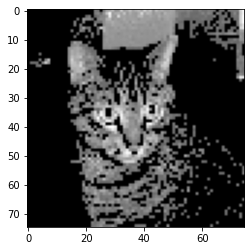

In [3]:
img = cv.imread('data/Cats and dogs/train/cat.1.jpg' ,0 )
img = cv.resize(img , (SIZE,SIZE))
ret, thresh1 = cv.threshold(img, 120, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)     
print(thresh1[0][74])

for x in range(SIZE):
    for y in range(SIZE):
        if thresh1[x][y]==0:
            img[x][y]=0


plt.imshow(img,cmap='gray')



In [4]:
def procces_image(img_path):
    img = cv.imread(img_path ,0)
    img = cv.resize(img , (SIZE,SIZE))

    ret, thresh1 = cv.threshold(img, 120, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)     

    for x in range(SIZE):
        for y in range(SIZE):
            if thresh1[x][y]==0:
                img[x][y]=0

    img = img.reshape(SIZE*SIZE)
    return img

In [5]:
def load_data(path):
    x = []
    y = []

    for file in os.listdir(path):
        label = file.split('.')[-3]
        data = procces_image("{}/{}".format(path,file))
        x.append(data)
        y.append(label)
    return x,y

In [6]:
X,Y = load_data('data/Cats and dogs/train')

In [7]:
X = np.asarray(X)
Y = np.asarray(Y)

In [8]:
from sklearn.model_selection import train_test_split
x_train,x_validate,y_train,y_validate = train_test_split(X,Y ,random_state=42)

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.decomposition import PCA

preprocess = Pipeline([
    ('scaler',MinMaxScaler()),
    ('pca',PCA(n_components=100)),
    ('shuffle' , shuffle(random_state=42))
])

In [10]:
x_reduced = preprocess.fit_transform(x_train)
x_validate_reduced = preprocess.transform(x_validate)

In [11]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(eta=0.05,max_depth=10,eval_metric='mlogloss')
xgb_clf.fit(x_reduced,y_train)
xgb_clf.score(x_validate_reduced,y_validate)

0.63488

In [12]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100,n_jobs=-1)

rf_clf.fit(x_reduced,y_train)
rf_clf.score(x_validate_reduced,y_validate)


0.61424

In [13]:
from sklearn.naive_bayes import GaussianNB


gnb_clf =  GaussianNB()

gnb_clf.fit(x_reduced,y_train)
gnb_clf.score(x_validate_reduced,y_validate)

0.57504

In [14]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf =  KNeighborsClassifier(n_neighbors=100,n_jobs=-1)

knn_clf.fit(x_reduced,y_train)
knn_clf.score(x_validate_reduced,y_validate)


0.60704

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
#629
ada_clf =  AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=250,learning_rate=0.2)

ada_clf.fit(x_reduced,y_train)
ada_clf.score(x_validate_reduced,y_validate)

0.61648

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
#629
ada_gb_clf =  AdaBoostClassifier(GaussianNB(),n_estimators=250,learning_rate=0.2)

ada_clf.fit(x_reduced,y_train)
ada_clf.score(x_validate_reduced,y_validate)

0.61664

In [20]:
from sklearn.ensemble import VotingClassifier
#63888
voting_clf = VotingClassifier(
    estimators=[('ada',ada_clf),    
                ('knn',knn_clf),
                ('rf',rf_clf),
                ('xgb',xgb_clf)],
            voting='soft',
            weights=[2,1,1,2],
)
voting_clf.fit(x_reduced, y_train)
voting_clf.score(x_validate_reduced,y_validate)

0.6464